In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap
from scipy.spatial import distance

Selected top 10 features using tree-based feature selection:
TEMP
TARGET_UF
TMP
SYRINGE_FLOW_RATE
MAX_BLOOD
BLOOD_FLOW
MIN_BLOOD
BREATH
PULSE
SYRINGE_FLOW


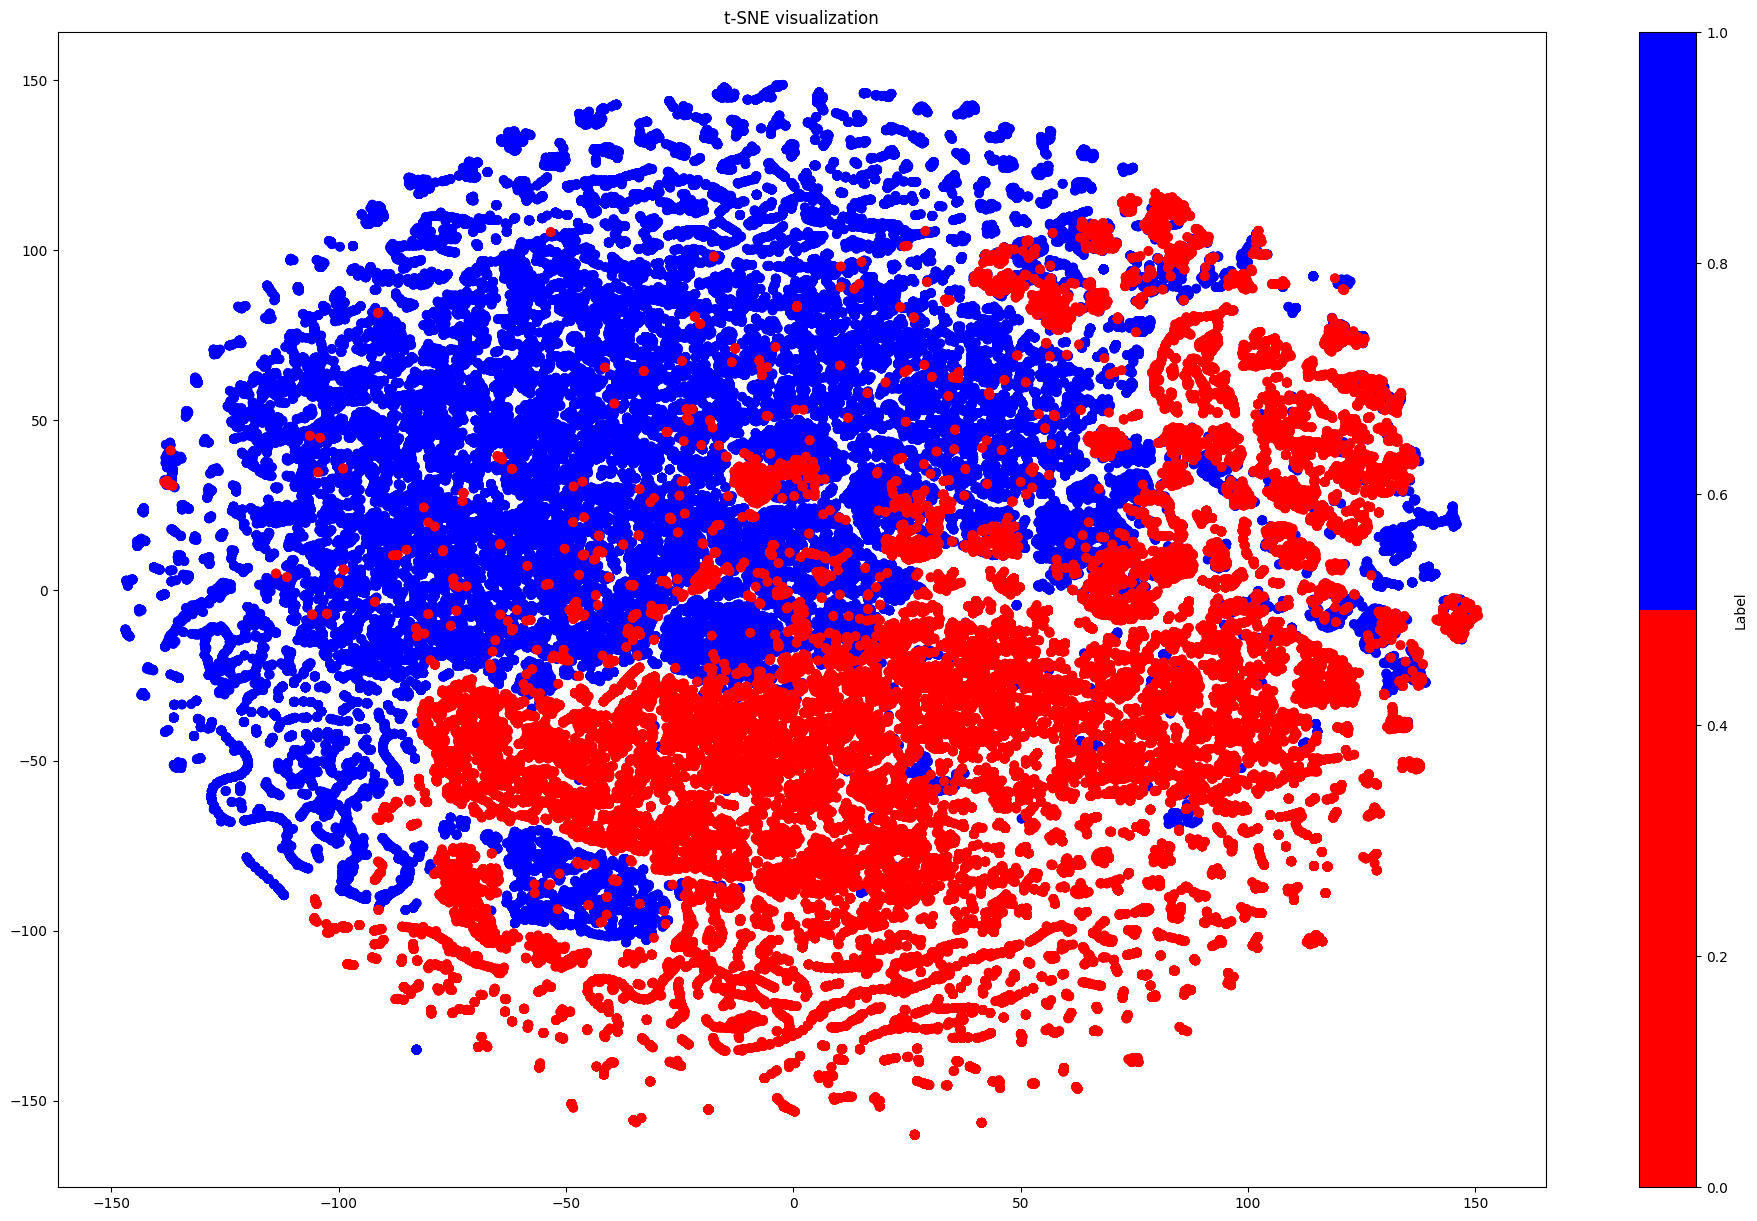

In [2]:


# Load datasets
dfAbnormal1 = pd.read_csv("../cleanData/clean_abnormal1.csv")
dfnormal1 = pd.read_csv("../cleanData/clean_normal.csv")
dfAbnormal = pd.read_csv("../cleanData/clean_abnormal1.csv")
dfnormal = pd.read_csv("../cleanData/clean_normal.csv")



dfAbnormal_1 = pd.concat([dfAbnormal, dfAbnormal1], ignore_index=True)
dfnormal_1 = pd.concat([dfnormal, dfnormal1], ignore_index=True)

# Define number of top features to select
k = 10  # Adjust this value as needed

# Combine datasets and add label columns
dfAbnormal_1['Label'] = 1
dfnormal_1['Label'] = 0
df_combined = pd.concat([dfAbnormal_1, dfnormal_1], ignore_index=True)

# Separate features and target
X = df_combined.drop(columns='Label')
y = df_combined['Label']

# Apply tree-based feature selection
model = ExtraTreesClassifier(random_state=42)
model.fit(X, y)
importances = model.feature_importances_

# Get indices of top k features
indices = np.argsort(importances)[-k:]

# Get selected feature names
selected_features = X.columns[indices]
print(f'Selected top {k} features using tree-based feature selection:')
for feature in selected_features:
    print(feature)

# Create a new dataframe with selected features and labels
df_selected = pd.DataFrame(X.iloc[:, indices], columns=selected_features)
df_selected['Label'] = y.values

# Standardize the data
X_standardized = StandardScaler().fit_transform(df_selected.drop(columns='Label'))

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_standardized)

# Create a new dataframe with t-SNE results
df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['Label'] = df_selected['Label']

# Plot t-SNE results
plt.figure(figsize=(24, 15))
scatter = plt.scatter(df_tsne['TSNE1'], df_tsne['TSNE2'], c=df_tsne['Label'], cmap=ListedColormap(['red', 'blue']))
plt.title('t-SNE visualization')
plt.colorbar(scatter, label='Label')
plt.show()


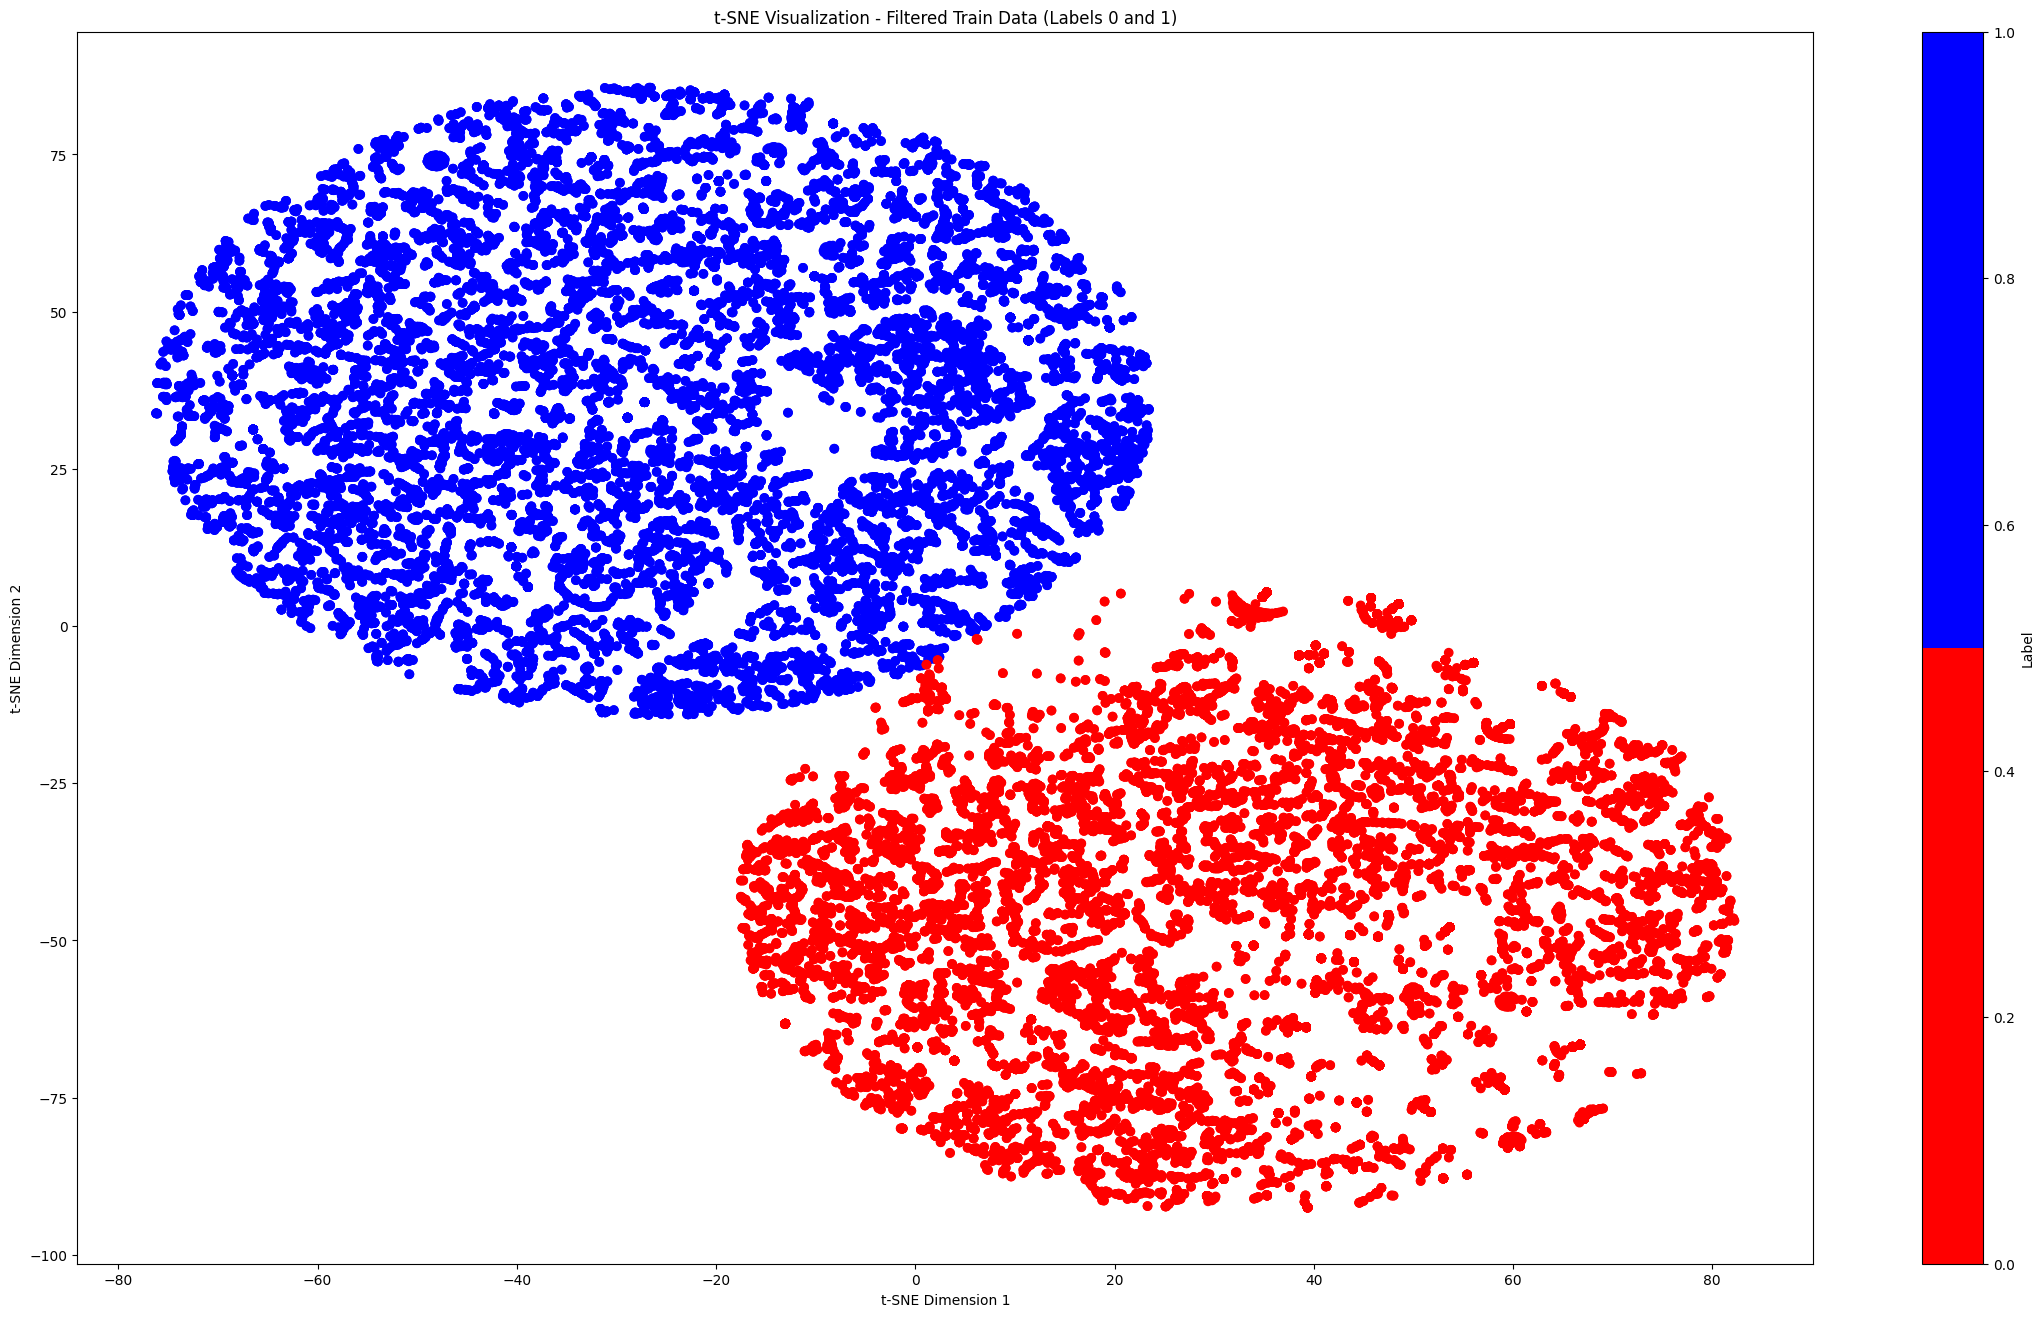

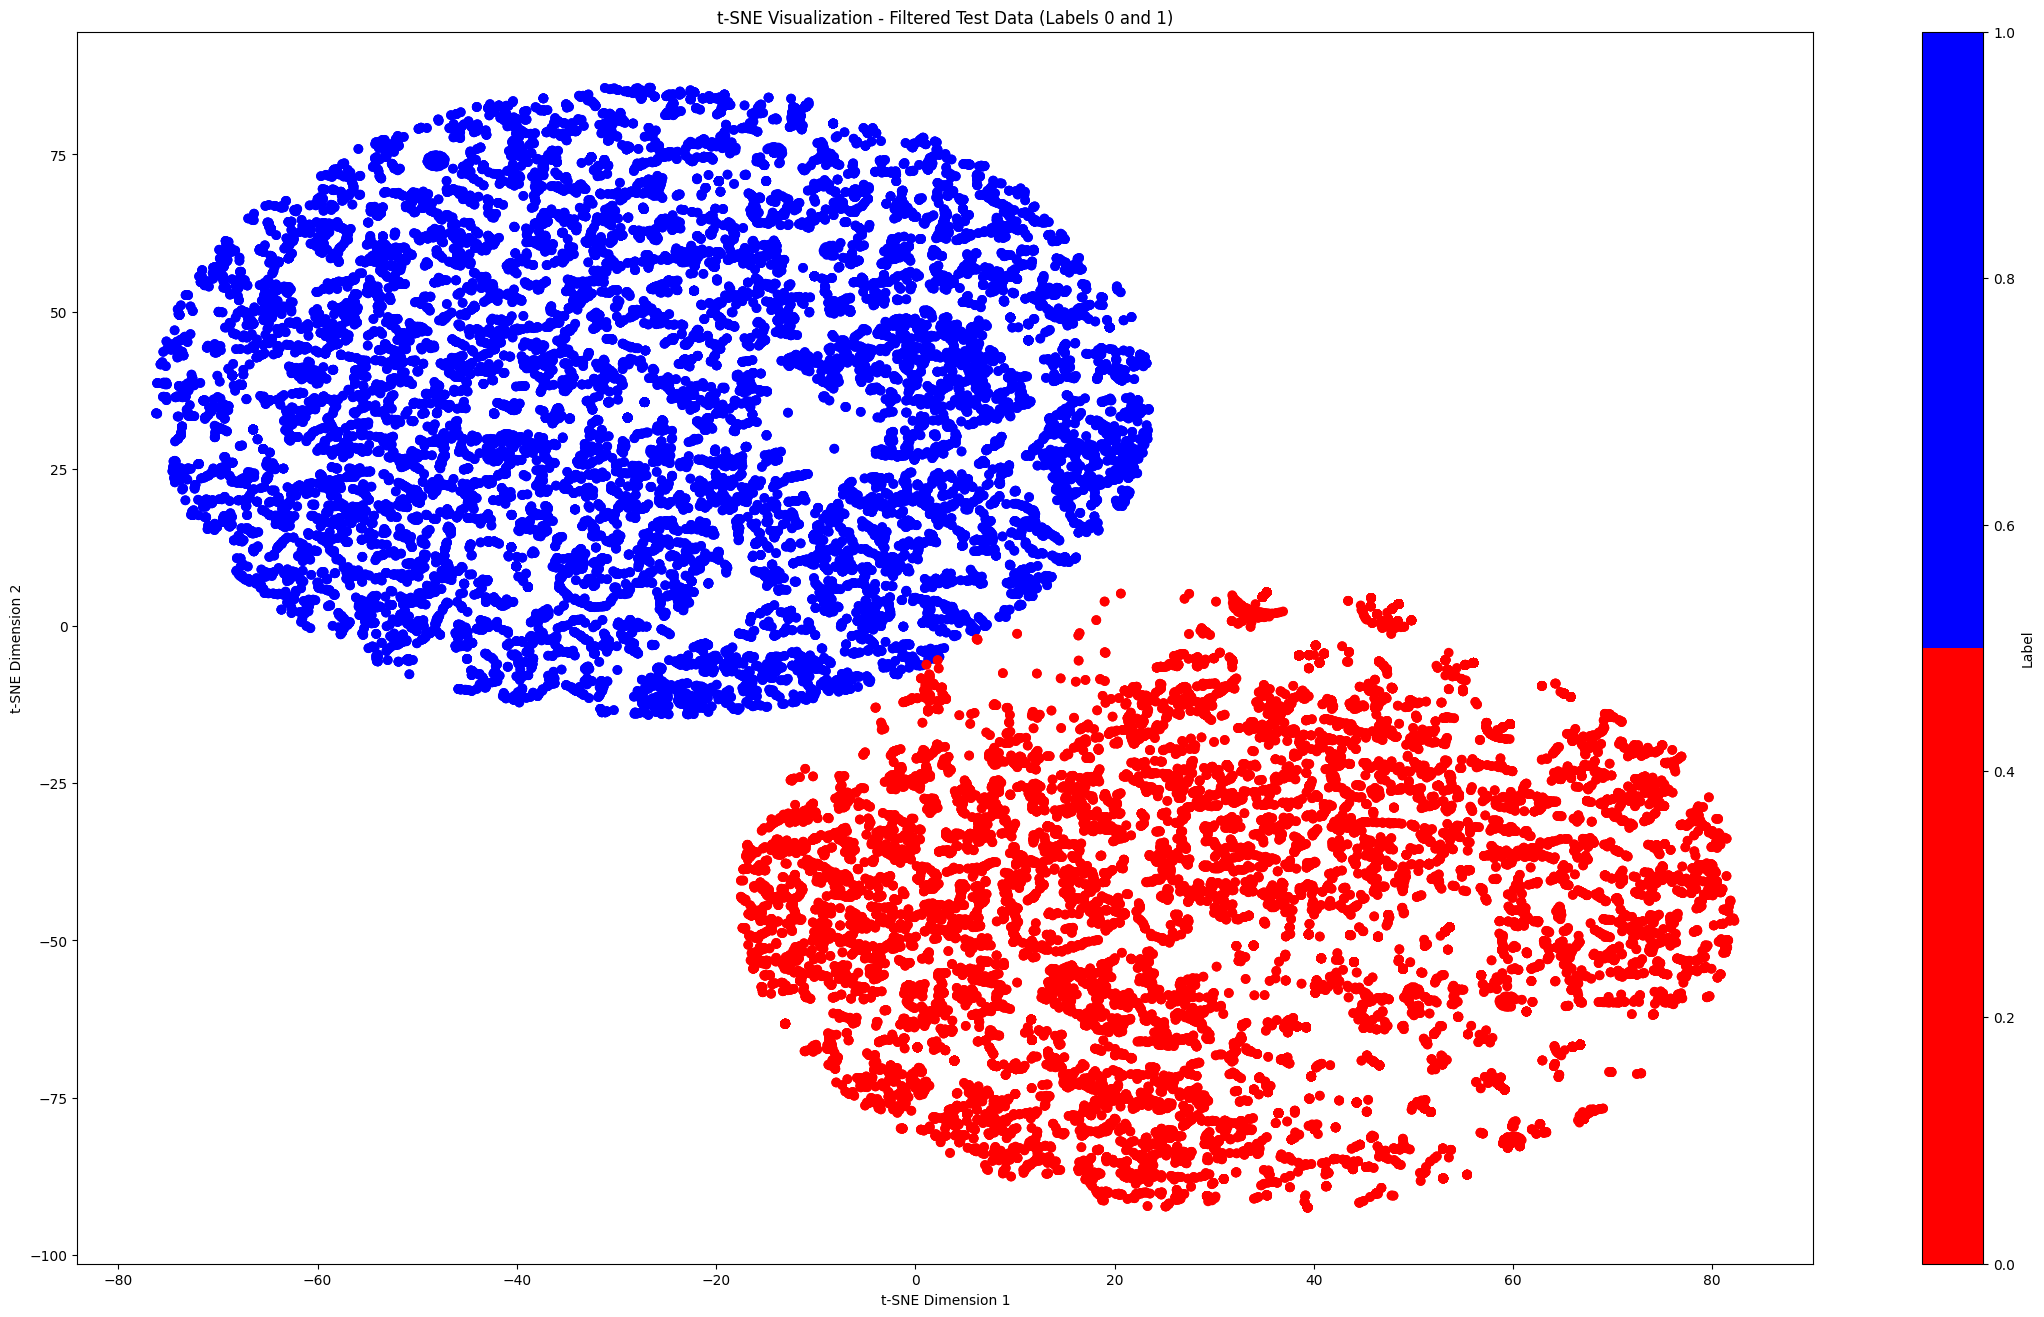

In [9]:
# 将数据分为训练和测试集 (这里需要您具体的训练和测试集划分逻辑)
# 在此示例中，假设所有数据都是训练数据（请根据实际情况进行修改）
train_tsne_embedded = df_tsne[['TSNE1', 'TSNE2']].values
train_labels = df_tsne['Label'].values
test_tsne_embedded = df_tsne[['TSNE1', 'TSNE2']].values
test_labels = df_tsne['Label'].values

# 计算类别的中心点
def compute_class_centers(points, labels):
    unique_labels = np.unique(labels)
    centers = {}
    for label in unique_labels:
        centers[label] = np.mean(points[labels == label], axis=0)
    return centers

# 定义阈值来过滤数据
distance_threshold = 50  # 这是一个示例阈值，请根据实际情况调整

# 筛选标签为0和1的训练数据点
train_mask = np.isin(train_labels, [0, 1])
train_tsne_embedded_01 = train_tsne_embedded[train_mask]
train_labels_01 = train_labels[train_mask]

# 筛选标签为0和1的测试数据点
test_mask = np.isin(test_labels, [0, 1])
test_tsne_embedded_01 = test_tsne_embedded[test_mask]
test_labels_01 = test_labels[test_mask]

# 计算训练数据的类别中心
train_class_centers = compute_class_centers(train_tsne_embedded_01, train_labels_01)

# 过滤训练数据
filtered_train_points = []
filtered_train_labels = []
for i, point in enumerate(train_tsne_embedded_01):
    label = train_labels_01[i]
    center = train_class_centers[label]
    if distance.euclidean(point, center) < distance_threshold:
        filtered_train_points.append(point)
        filtered_train_labels.append(label)

filtered_train_points = np.array(filtered_train_points)
filtered_train_labels = np.array(filtered_train_labels)

# 计算测试数据的类别中心
test_class_centers = compute_class_centers(test_tsne_embedded_01, test_labels_01)

# 过滤测试数据
filtered_test_points = []
filtered_test_labels = []
for i, point in enumerate(test_tsne_embedded_01):
    label = test_labels_01[i]
    center = test_class_centers[label]
    if distance.euclidean(point, center) < distance_threshold:
        filtered_test_points.append(point)
        filtered_test_labels.append(label)

filtered_test_points = np.array(filtered_test_points)
filtered_test_labels = np.array(filtered_test_labels)

# 可视化过滤后的训练数据
plt.figure(figsize=(28, 16))
plt.scatter(filtered_train_points[:, 0], filtered_train_points[:, 1], c=filtered_train_labels, cmap=ListedColormap(['red', 'blue']))
plt.title('t-SNE Visualization - Filtered Train Data (Labels 0 and 1)')
plt.colorbar(label='Label')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

# 可视化过滤后的测试数据
plt.figure(figsize=(28, 16))
plt.scatter(filtered_test_points[:, 0], filtered_test_points[:, 1], c=filtered_test_labels, cmap=ListedColormap(['red', 'blue']))
plt.title('t-SNE Visualization - Filtered Test Data (Labels 0 and 1)')
plt.colorbar(label='Label')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


In [10]:
# 创建一个哈希表，以加快查找速度
point_to_index = {tuple(point): index for index, point in enumerate(train_tsne_embedded)}

# 使用哈希表查找每个点的索引
indices = np.array([point_to_index[tuple(point)] for point in filtered_train_points])

selected_rows = df_selected.iloc[indices]

df_final = pd.DataFrame(selected_rows)

In [11]:
df_final

,TEMP,TARGET_UF,TMP,SYRINGE_FLOW_RATE,MAX_BLOOD,BLOOD_FLOW,MIN_BLOOD,BREATH,PULSE,SYRINGE_FLOW,Label
56649,36.0,4.0,76.0,0.5,127.0,270.0,66.0,15.852175,84.0,3.062776,1
56650,36.0,2.9,59.0,0.5,127.0,184.0,66.0,15.852175,84.0,3.062776,1
56651,36.0,2.9,64.0,0.5,127.0,270.0,66.0,15.852175,84.0,3.062776,1
56652,36.1,2.9,69.0,0.5,139.0,270.0,59.0,16.000000,83.0,3.000000,1
56653,36.1,2.9,69.0,0.5,139.0,270.0,59.0,15.852175,83.0,3.062776,1
...,...,...,...,...,...,...,...,...,...,...,...
207672,36.9,3.5,57.0,1.0,128.0,221.0,68.0,15.482281,80.0,2.957738,0
207673,36.9,3.5,61.0,1.0,128.0,184.0,68.0,15.482281,80.0,2.957738,0
207675,36.9,3.5,81.0,1.0,128.0,159.0,68.0,15.482281,80.0,2.957738,0
207676,36.9,3.5,57.0,0.0,148.0,159.0,69.0,15.482281,76.0,2.957738,0


In [12]:
df_final.to_csv("../cnnData/tree-based.csv")